#### imports etc 

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.datasets import ImageFolder
import pickle
from collections import Counter

from dotenv import load_dotenv
load_dotenv()

PATH_TO_PLANTNET_300K = os.environ.get('PATH_TO_PLANTNET_300K')


Number of folders: 10


# For 10 classes

In [ ]:

def count_folders(directory):
    return len([name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))])

train_set = f'{PATH_TO_PLANTNET_300K}/train_temp'

import resnet
class_no = count_folders(train_set)
print(f"Number of folders: {class_no}")


#### Getting metrics 

In [ ]:
metrics = resnet.train_and_evaluate(num_epochs=4, num_classes = count_folders(train_set))

with open('metrics_data_10.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [7]:
with open('metrics_data_10.pkl', 'rb') as f:
    metrics = pickle.load(f)

#### data in CLI

In [8]:
for epoch_data in metrics:
        print(f"\nEpoch {epoch_data['epoch']} Metrics:")
        print(f"Loss: {epoch_data['loss']:.4f}")
        print(f"Overall Accuracy: {epoch_data['overall_accuracy']:.2f}%")
        print(f"Confusion Matrix:\n{epoch_data['confusion_matrix']}")
        print(f"report {epoch_data['classification_report']}")
        print("Top 5 classes with the best recall:")
        for cls, recall in epoch_data['top_5_best_recall']:
            print(f"Class {cls}: {recall:.2f}")

        print("\nTop 5 classes with the worst recall:")
        for cls, recall in epoch_data['top_5_worst_recall']:
            print(f"Class {cls}: {recall:.2f}")


Epoch 1 Metrics:
Loss: 0.4966
Overall Accuracy: 94.73%
Confusion Matrix:
[[147   1   3   0   0   0   0   0   1   2]
 [  3  45   4   0   0   1   1   0   0   0]
 [  1   2  62   1   0   0   1   0   0   0]
 [  2   2   3  85   0   1   1   0   0   0]
 [  1   0   0   0  27   1   0   1   0   0]
 [  4   2   2   0   6 196   0   0   0   1]
 [  0   1   0   1   0   0 279   0   0   0]
 [  1   0   0   0   0   0   0 131   0   1]
 [  0   0   0   0   0   0   2   2  29   0]
 [  1   0   0   1   0   0   0   0   0  42]]
report {'1409238': {'precision': 0.91875, 'recall': 0.9545454545454546, 'f1-score': 0.9363057324840764, 'support': 154.0}, '1393425': {'precision': 0.8490566037735849, 'recall': 0.8333333333333334, 'f1-score': 0.8411214953271028, 'support': 54.0}, '1390637': {'precision': 0.8378378378378378, 'recall': 0.9253731343283582, 'f1-score': 0.8794326241134752, 'support': 67.0}, '1355990': {'precision': 0.9659090909090909, 'recall': 0.9042553191489362, 'f1-score': 0.9340659340659341, 'support': 94.0

#### Number of photos in the class 

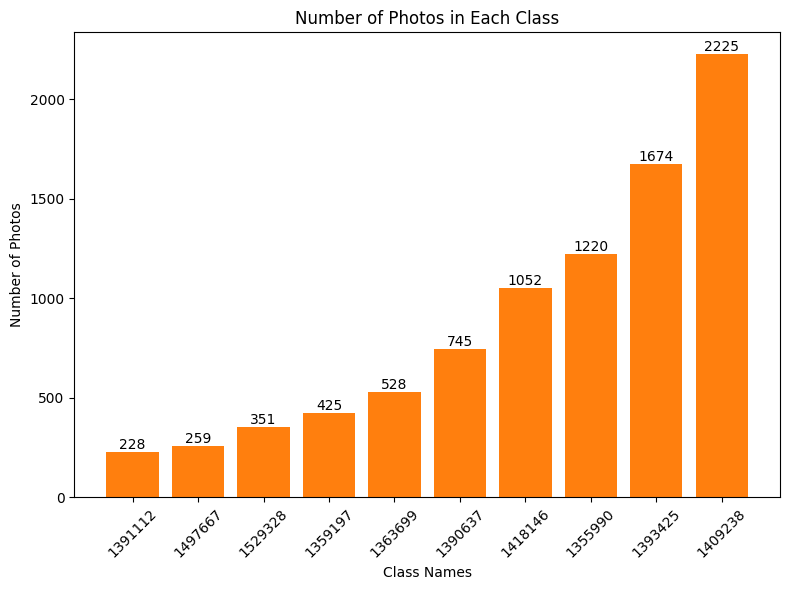

In [58]:
train_path = os.path.join(PATH_TO_PLANTNET_300K, 'train_temp') 
train_dataset = ImageFolder(root=train_path)

class_counts_dict = Counter([label for _, label in train_dataset])
class_counts = np.array([class_counts_dict[i] for i in range(len(train_dataset.classes))])

class_names = sorted(resnet.get_class_names(f'{PATH_TO_PLANTNET_300K}/train_temp'))

sorted_indices = np.argsort(class_counts)
sorted_class_counts = class_counts[sorted_indices]
sorted_class_names = [class_names[i] for i in sorted_indices]

plt.figure(figsize=(8, 6))
plt.bar(sorted_class_names, sorted_class_counts)
bars = plt.bar(sorted_class_names, sorted_class_counts)
for bar, count in zip(bars, sorted_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
             ha='center', va='bottom', fontsize=10)

plt.title('Number of Photos in Each Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Photos')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


#### Accuray per epoch 

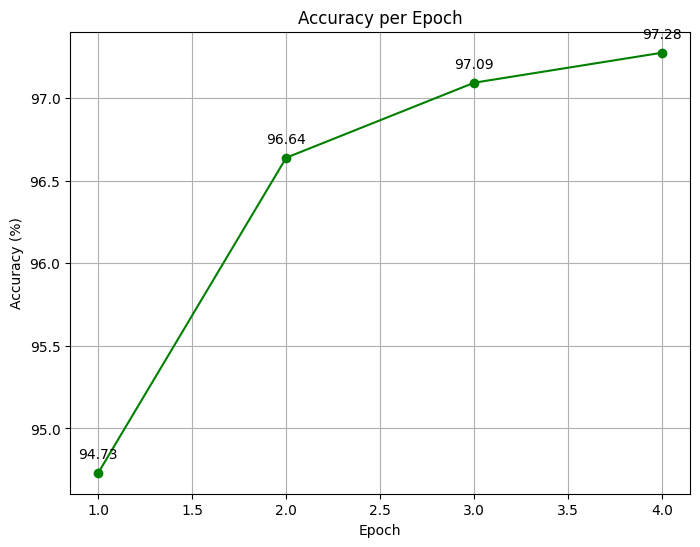

In [26]:
accuracy_per_epoch = [epoch_data['overall_accuracy'] for epoch_data in metrics]

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(accuracy_per_epoch) + 1), accuracy_per_epoch, marker='o', color='green')
for i, value in enumerate(accuracy_per_epoch):
    plt.annotate(f'{value:.2f}', (i + 1, value), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


#### Confusion Matrix for Last Epoch 

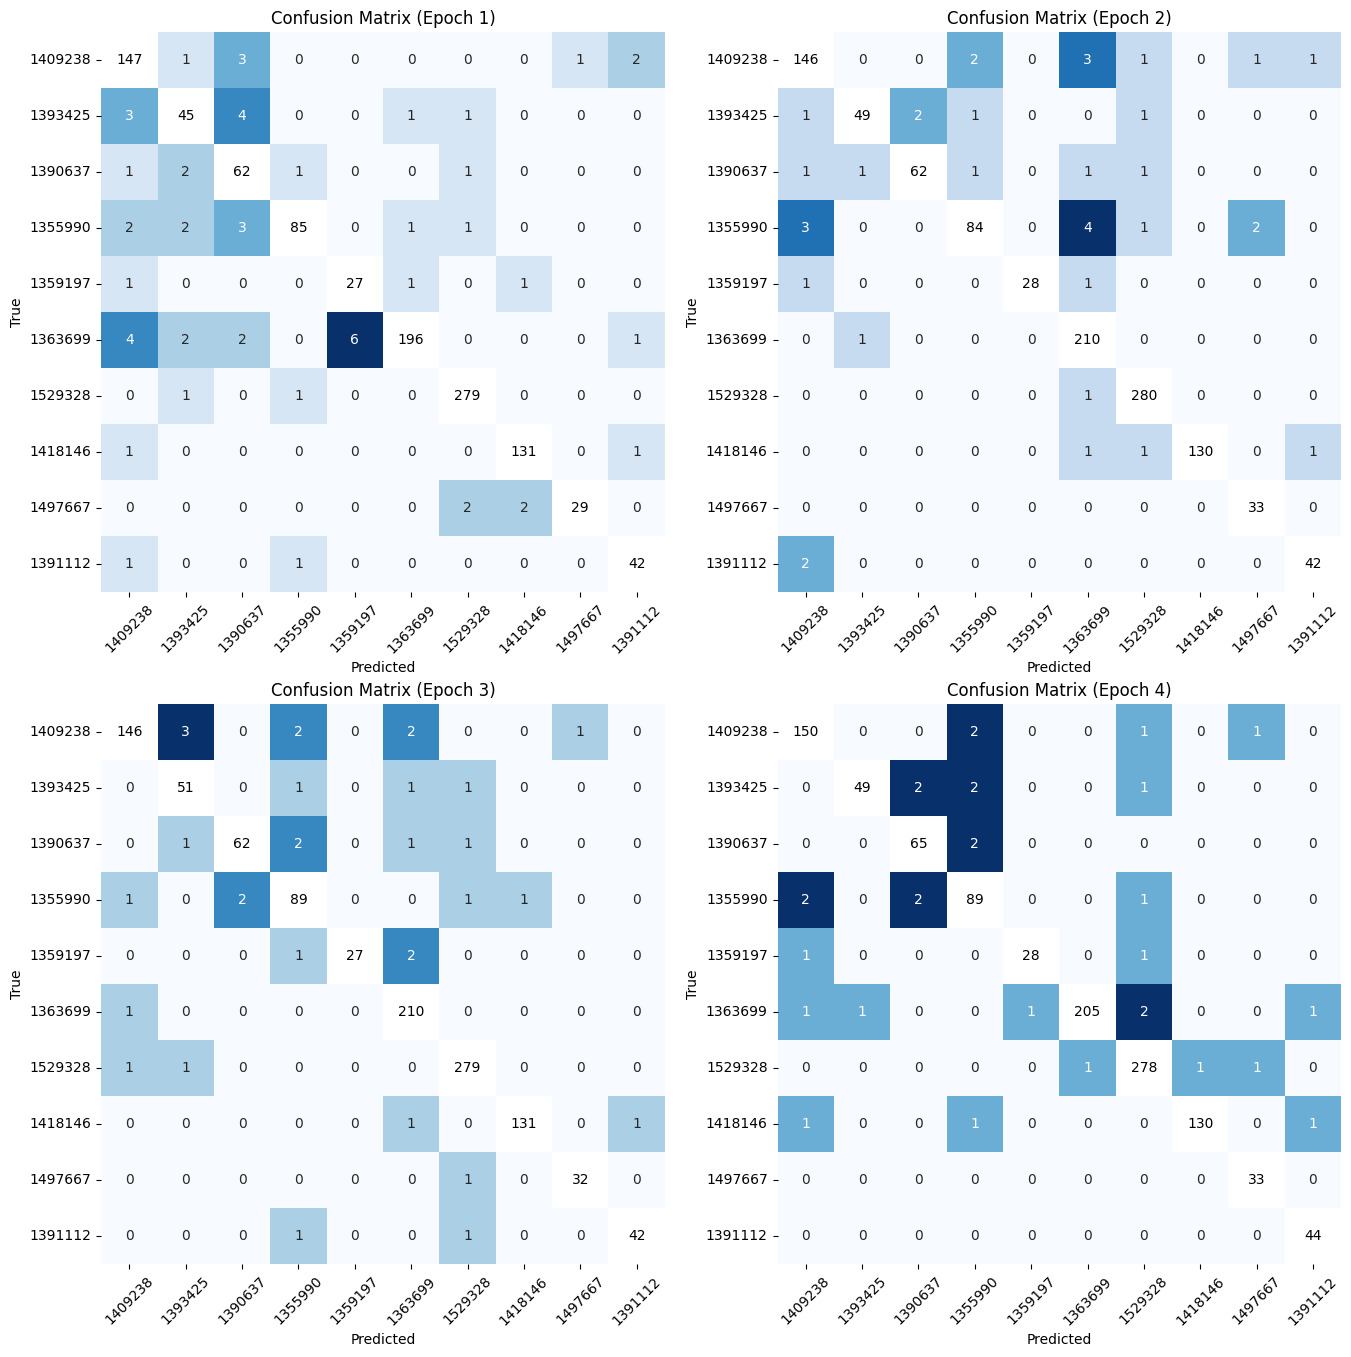

In [92]:
num_epochs = len(metrics)
n_rows = (num_epochs + 1) // 2 

fig, axes = plt.subplots(n_rows, 2, figsize=(16, n_rows * 8))

axes = axes.flatten() #(?) 

for epoch in range(num_epochs):

    conf_matrix = metrics[epoch]['confusion_matrix']
    selected_classes = resnet.get_class_names(f'{PATH_TO_PLANTNET_300K}/train_temp') 

    conf_matrix_for_coloring = conf_matrix.astype(float)
    np.fill_diagonal(conf_matrix_for_coloring, np.nan)

    sns.heatmap(conf_matrix_for_coloring, annot=conf_matrix, cmap='Blues', ax=axes[epoch],
                xticklabels=selected_classes, yticklabels=selected_classes,
                mask=np.isnan(conf_matrix_for_coloring),
                cbar=False)
    
    for i in range(len(conf_matrix)):
        axes[epoch].text(i + 0.5, i + 0.5, conf_matrix[i, i], ha="center", va="center", color="black", fontsize=10)

    axes[epoch].set_title(f'Confusion Matrix (Epoch {epoch + 1})')
    axes[epoch].tick_params(axis='x', rotation=45)
    axes[epoch].set_xlabel('Predicted')
    axes[epoch].set_ylabel('True')


plt.show()



##### Best and Worst recall

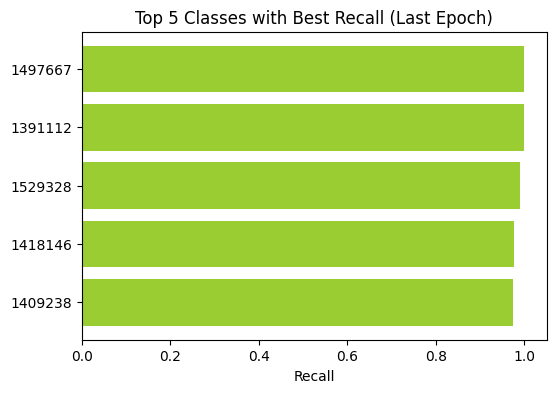

In [84]:
top_5_best_recall = metrics[-1]['top_5_best_recall']

classes, recalls = zip(*top_5_best_recall)

plt.figure(figsize=(6, 4))
plt.barh(classes, recalls, color='yellowgreen')
plt.title('Top 5 Classes with Best Recall (Last Epoch)')
plt.xlabel('Recall')
plt.gca().invert_yaxis()
plt.show()

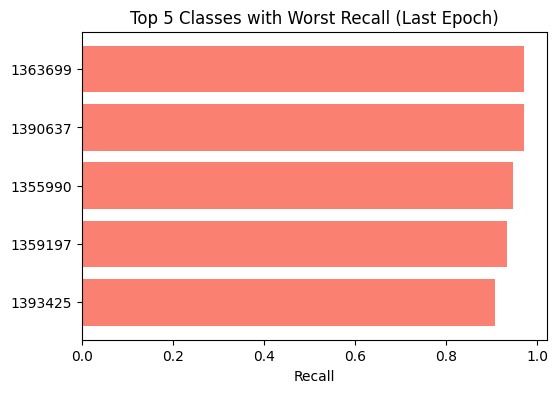

In [83]:
top_5_worst_recall = metrics[-1]['top_5_worst_recall']

classes, recalls = zip(*top_5_worst_recall)

plt.figure(figsize=(6, 4))
plt.barh(classes, recalls, color='salmon')
plt.title('Top 5 Classes with Worst Recall (Last Epoch)')
plt.xlabel('Recall')
plt.show()


#### Best and Worst F1

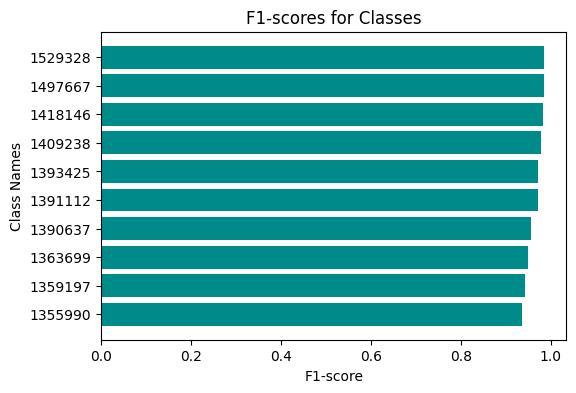

In [80]:
last_epoch_report = metrics[-1]['classification_report']

f1_scores = {class_name: last_epoch_report[class_name]['f1-score'] for class_name in last_epoch_report if class_name not in ['accuracy', 'macro avg', 'weighted avg']}

sorted_f1 = dict(sorted(f1_scores.items(), key=lambda item: item[1]))

class_name, f1_score = zip(*sorted_f1.items())

plt.figure(figsize=(6, 4))
plt.barh(class_names, f1_score, color='darkcyan')

plt.xlabel('F1-score')
plt.ylabel('Class Names')
plt.title('F1-scores for Classes')

plt.show()

# For all classes

### Usuwanie klas z malym recall 

In [ ]:
import os
import pickle
from dotenv import load_dotenv
load_dotenv()
import shutil

PATH_TO_PLANTNET_300K = os.environ.get('PATH_TO_PLANTNET_300K')
image_dir_train = os.path.join(PATH_TO_PLANTNET_300K, 'train')
image_dir_test = os.path.join(PATH_TO_PLANTNET_300K, 'test')
image_dir_val = os.path.join(PATH_TO_PLANTNET_300K, 'val')

with open('metrics_data.pkl', 'rb') as f:
    metrics_all = pickle.load(f)

last_epoch_report = metrics_all[-1]['classification_report']

recalls = {class_name: last_epoch_report[class_name]['recall'] for class_name in last_epoch_report if class_name not in ['accuracy', 'macro avg', 'weighted avg']}

i = 0 
for class_name, recall in recalls.items():
    class_dir_train = os.path.join(image_dir_train, class_name)
    class_dir_test = os.path.join(image_dir_test, class_name)
    class_dir_val = os.path.join(image_dir_val, class_name)

    if recall < 0.5:
        print(f"Class {class_name} has a recall of {recall:.2f}")
        small_recall_path = os.path.join(image_dir_train, class_name)
        try:
            shutil.rmtree(class_dir_train)
            shutil.rmtree(class_dir_test)
            shutil.rmtree(class_dir_val)
            print(f"Deleted directory: {class_name}")
        except Exception as e:
                print(f"Error deleting directory {class_name}: {e}")
        i = i + 1

print(f"number of calss: {i}")

